This is a simple test quickstart on the overall library as currently avalaible on Github

``` This specifically shows that midcircuit measure does not work as is ```

In [1]:
# Standard libraries
import numpy as np
import json
import os
from dotenv import load_dotenv

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeBrisbane


# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend



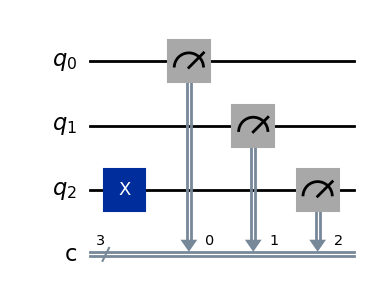

In [2]:
# --- 1. Define a circuit that makes SWAPs matter ---
N_q = 3
qc = QuantumCircuit(N_q, N_q)
# Prepare |01>
qc.x(2)

# Apply SWAP
#qc.swap(0, 1)

# Measure
qc.measure(range(N_q), range(N_q))

qc.draw('mpl')

In [ ]:
# call the simulator
sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

''' 
# For Noise free simulation
from quantum_gates.gates import NoiseFreeGates 

sim = MrAndersonSimulator(
    gates=NoiseFreeGates,        # <- ideal gates (no noise)
    CircuitClass=EfficientCircuit
)
'''

bit_flip_bool = True # turn on/off for readout noise

initial_psi = np.zeros(2**N_q)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(N_q))  # logical qubit 0→physical 0, 1→1, etc.
shots = 200

### To use a real backend from IBM Quantum, uncomment and set up the following:

### Here we use a Fake Backend for simplicity

In [3]:
# 1) Pick a fake backend
backend = FakeBrisbane()  # 127 qubits; change to another Fake*V2 if import fails

# 2) Use only N qubits
qubits_layout = list(range(N_q))

# 3) Load via YOUR class and save JSON next to the script
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()
#device_param.save_to_json("./")  # writes ./device_parameters.json
#print("Wrote ./device_parameters.json")

In [5]:
needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=42,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

probs = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=initial_psi, 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=N_q,
    )

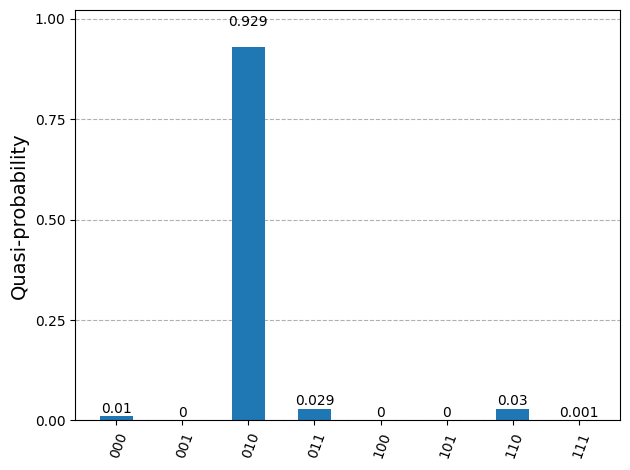

In [6]:
plot_histogram(probs)

Comparison with AER

In [7]:
# Simulate with Aer
sim = AerSimulator()
t_qc = transpile(qc, sim)
result = sim.run(t_qc, shots=shots).result()
counts = result.get_counts()

Aer All clbits counts: {'100': 200}


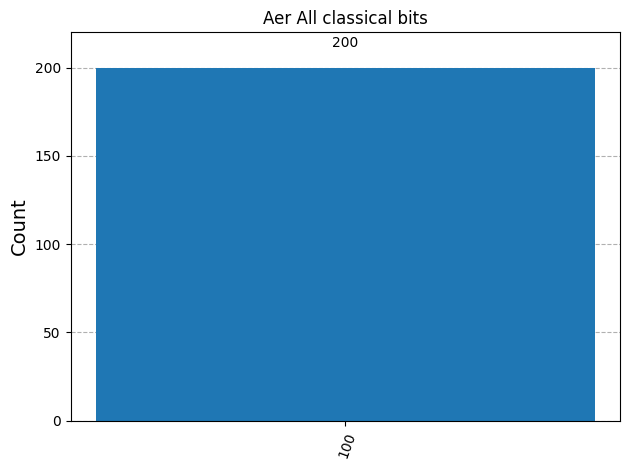

In [8]:
print("Aer All clbits counts:", counts)
plot_histogram(counts, title="Aer All classical bits")